In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data_dir = '/kaggle/input/PBC_dataset_normal_DIB'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
indices = list(range(len(full_dataset)))

In [3]:
dataper = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3]

accuracies = {f"test_{i+1}":[] for i in range(10)}
test_acc_per = 0

# Ensure that the test set is fixed with 4000 images
train_idx, test_idx = train_test_split(indices, test_size=4000, random_state=42)
test_dataset = Subset(full_dataset, test_idx)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Test set: {len(test_dataset)} images")

Test set: 4000 images


In [4]:
mod_dataper = [i * (len(full_dataset)/(len(full_dataset)-4000)) for i in dataper]
mod_dataper

[0.013055300947143293,
 0.032638252367858236,
 0.06527650473571647,
 0.0979147571035747,
 0.13055300947143295,
 0.2611060189428659,
 0.3916590284142988]

In [5]:
for _ in range(10):
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print(f"Started {_+1} set")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    for i,j in zip(mod_dataper,dataper):
        # Split the remaining indices for training and validation
        remaining_indices = [idx for idx in indices if idx not in test_idx]
        train_idx, val_idx = train_test_split(remaining_indices, train_size=i, random_state=42)
        val_idx, val_idx_no_use = train_test_split(val_idx, train_size=0.02, random_state=42)

        train_dataset = Subset(full_dataset, train_idx)
        val_dataset = Subset(full_dataset, val_idx)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        print(f"Train set: {len(train_dataset)} images")
        print(f"Validation set: {len(val_dataset)} images")

        num_classes = 8

        model = models.mobilenet_v2(pretrained=True)

        # Modify the final fully connected layer to match the number of classes
        model.classifier[1] = nn.Linear(model.last_channel, num_classes)

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
            best_acc = 0.0
            for epoch in range(num_epochs):
                print(f'Epoch {epoch+1}/{num_epochs}')
                print('-' * 10)

                model.train()
                running_loss = 0.0
                correct = 0
                total = 0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    correct += torch.sum(preds == labels.data)
                    total += labels.size(0)

                epoch_loss = running_loss / len(train_loader.dataset)
                epoch_acc = correct.double() / len(train_loader.dataset)

                print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Validation phase
                model.eval()
                val_loss = 0.0
                correct = 0
                total = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        val_loss += loss.item() * inputs.size(0)
                        _, preds = torch.max(outputs, 1)
                        correct += torch.sum(preds == labels.data)
                        total += labels.size(0)

                val_loss = val_loss / len(val_loader.dataset)
                val_acc = correct.double() / len(val_loader.dataset)

                print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

                # Step scheduler
                scheduler.step()

                # Save the model if validation accuracy improves
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model.state_dict(), f'best_mobilenetv2_{j*100}.pth')
                    print(f"Best model saved with accuracy: {best_acc:.4f}")
                    train_acc_per = round(epoch_acc.item(), 4)
                    val_acc_per = round(val_acc.item(), 4)

        # Train the model with dynamic number of epochs
        train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

        # Evaluate the model on the test dataset
        def test_model(model, test_loader):
            model.load_state_dict(torch.load(f'best_mobilenetv2_{j*100}.pth'))
            model.eval()

            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    correct += torch.sum(preds == labels.data)
                    total += labels.size(0)

            test_acc = correct.double() / total
            print(f'Test Accuracy: {test_acc:.4f}')
            return round(test_acc.item(), 4)

        # Test the model
        test_acc_per = test_model(model, test_loader)
        accuracies[f"test_{_+1}"].append(test_acc_per)
        print(f'Done for {j*100} % data')

    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print(f"Ended {_+1} set")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")
    print("-----------------------------------------------------")

-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------
Started 1 set
-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Train set: 170 images
Validation set: 258 images


100%|██████████| 13.6M/13.6M [00:00<00:00, 132MB/s]


Epoch 1/10
----------
Train Loss: 1.4779 Acc: 0.4647
Val Loss: 2.1727 Acc: 0.3837
Best model saved with accuracy: 0.3837
Epoch 2/10
----------
Train Loss: 0.6318 Acc: 0.8118
Val Loss: 2.3978 Acc: 0.5775
Best model saved with accuracy: 0.5775
Epoch 3/10
----------
Train Loss: 0.6027 Acc: 0.7824
Val Loss: 2.4004 Acc: 0.5155
Epoch 4/10
----------
Train Loss: 0.5734 Acc: 0.8412
Val Loss: 0.7606 Acc: 0.7984
Best model saved with accuracy: 0.7984
Epoch 5/10
----------
Train Loss: 0.4881 Acc: 0.8588
Val Loss: 0.8715 Acc: 0.7674
Epoch 6/10
----------
Train Loss: 0.4454 Acc: 0.8412
Val Loss: 0.6725 Acc: 0.8295
Best model saved with accuracy: 0.8295
Epoch 7/10
----------
Train Loss: 0.2935 Acc: 0.8941
Val Loss: 0.5937 Acc: 0.8217
Epoch 8/10
----------
Train Loss: 0.2537 Acc: 0.9353
Val Loss: 0.4172 Acc: 0.8798
Best model saved with accuracy: 0.8798
Epoch 9/10
----------
Train Loss: 0.2962 Acc: 0.9118
Val Loss: 0.3295 Acc: 0.9031
Best model saved with accuracy: 0.9031
Epoch 10/10
----------
Train

/tmp/ipykernel_30/4125752349.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_mobilenetv2_{j*100}.pth'))


Test Accuracy: 0.8905
Done for 1.0 % data
Train set: 427 images
Validation set: 253 images
Epoch 1/10
----------
Train Loss: 0.9174 Acc: 0.6885
Val Loss: 2.1497 Acc: 0.5731
Best model saved with accuracy: 0.5731
Epoch 2/10
----------
Train Loss: 0.5820 Acc: 0.7869
Val Loss: 1.2885 Acc: 0.7431
Best model saved with accuracy: 0.7431
Epoch 3/10
----------
Train Loss: 0.5794 Acc: 0.8056
Val Loss: 1.1616 Acc: 0.7312
Epoch 4/10
----------
Train Loss: 0.4542 Acc: 0.8478
Val Loss: 0.6104 Acc: 0.8221
Best model saved with accuracy: 0.8221
Epoch 5/10
----------
Train Loss: 0.4480 Acc: 0.8407
Val Loss: 0.7199 Acc: 0.7866
Epoch 6/10
----------
Train Loss: 0.4116 Acc: 0.8501
Val Loss: 0.7727 Acc: 0.7431
Epoch 7/10
----------
Train Loss: 0.3683 Acc: 0.8665
Val Loss: 0.4463 Acc: 0.8775
Best model saved with accuracy: 0.8775
Epoch 8/10
----------
Train Loss: 0.3352 Acc: 0.8946
Val Loss: 0.3301 Acc: 0.8972
Best model saved with accuracy: 0.8972
Epoch 9/10
----------
Train Loss: 0.2691 Acc: 0.9180
Val L

In [6]:
acc_for_each_split = []
for i in range(len(dataper)):
    temp = []
    for j in range(10):
        temp.append(accuracies[f"test_{j+1}"][i])
    acc_for_each_split.append(temp)


avg_acc = []
stds = []
for i in range(len(dataper)):
    avg_acc.append(sum(acc_for_each_split[i])/len(acc_for_each_split[i]))
    stds.append(np.std(acc_for_each_split[i]))

In [7]:
print(avg_acc)
print(stds)

[0.85739, 0.91558, 0.9287000000000001, 0.9367099999999999, 0.94725, 0.9569499999999997, 0.9583300000000001]
[0.02787728286616184, 0.007251730827878266, 0.003922244255525164, 0.0038666393677197195, 0.0037256543049510185, 0.0024691091510907225, 0.008634703237517785]


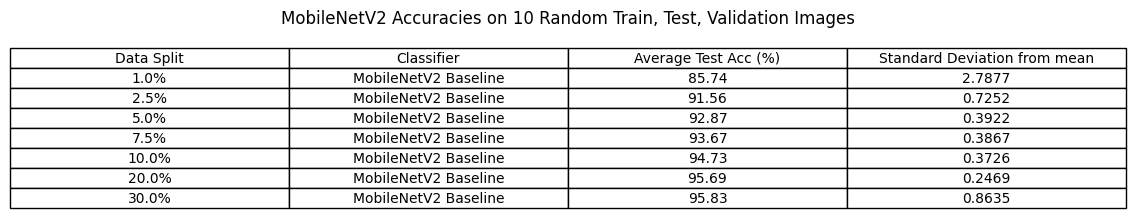

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
data = {
        'Data Split': [f'{i*100}%' for i in dataper],
        'Classifier': ['MobileNetV2 Baseline' for i in range(len(dataper))],
        'Average Test Acc (%)': [round(avg_acc[i]*100,2) for i in range(len(dataper))],
        'Standard Deviation from mean' : [round(i*100,4) for i in stds] 
}

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title(f'MobileNetV2 Accuracies on 10 Random Train, Test, Validation Images', pad=20)
plt.show()

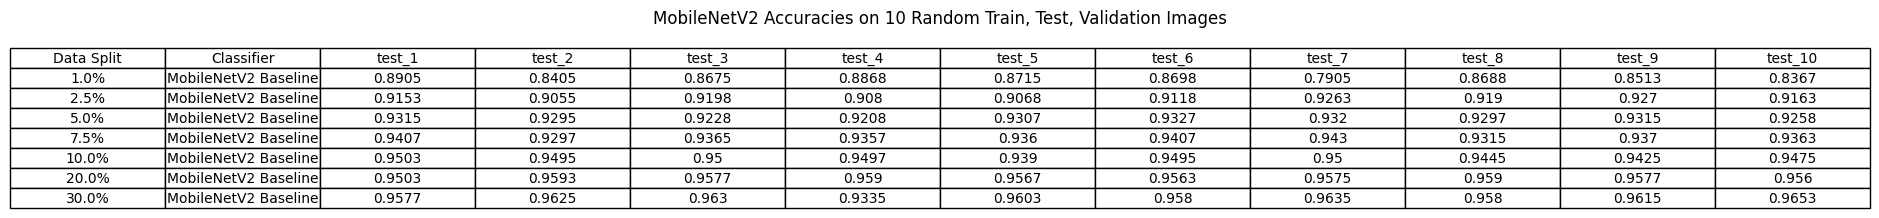

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
data_half = {
    'Data Split': [f'{i*100}%' for i in dataper],
    'Classifier': ['MobileNetV2 Baseline' for i in range(len(dataper))]
}
data = {**data_half, **accuracies}
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(20, 2))
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2) 
plt.title(f'MobileNetV2 Accuracies on 10 Random Train, Test, Validation Images', pad=20)
plt.show()